In [12]:
from common import plot_standings_v2, NWSL
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
week = 4
year = 2023

In [14]:
df = pd.read_csv("data/" + str(year) + "/1.csv", index_col=0)[["rank"]].rename(
    columns={"rank": "1"}
)
for i in range(2, week + 1):
    df_new = pd.read_csv("data/" + str(year) + "/" + str(i) + ".csv", index_col=0)[
        ["rank"]
    ].rename(columns={"rank": str(i)})
    df = df.join(df_new)
df

,1,2,3,4
team,,,,
POR,1,1,1,1
SD,2,2,3,3
NJNY,3,6,5,4
NC,4,8,10,10
WAS,5,3,2,5
LOU,6,9,9,8
HOU,7,4,6,6
CHI,8,10,8,9
LA,9,7,7,7


In [15]:
# Create fake data for the standings table
df_table = pd.read_csv("data/" + str(year) + "/" + str(week) +".csv", index_col=0)
df_table

,rank,PTS,MP,W,L,D,GF,GA,GD
team,,,,,,,,,
POR,1,10,4,3,0,1,11,2,9
RGN,2,9,4,3,1,0,8,3,5
SD,3,9,4,3,1,0,8,4,4
NJNY,4,9,4,3,1,0,5,3,2
WAS,5,8,4,2,0,2,5,3,2
HOU,6,6,4,1,0,3,3,2,1
LA,7,4,4,1,2,1,5,7,-2
LOU,8,3,4,0,1,3,4,6,-2
CHI,9,3,4,1,3,0,9,12,-3


/home/agale/soccer-analytics/src/common/plot_standings.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

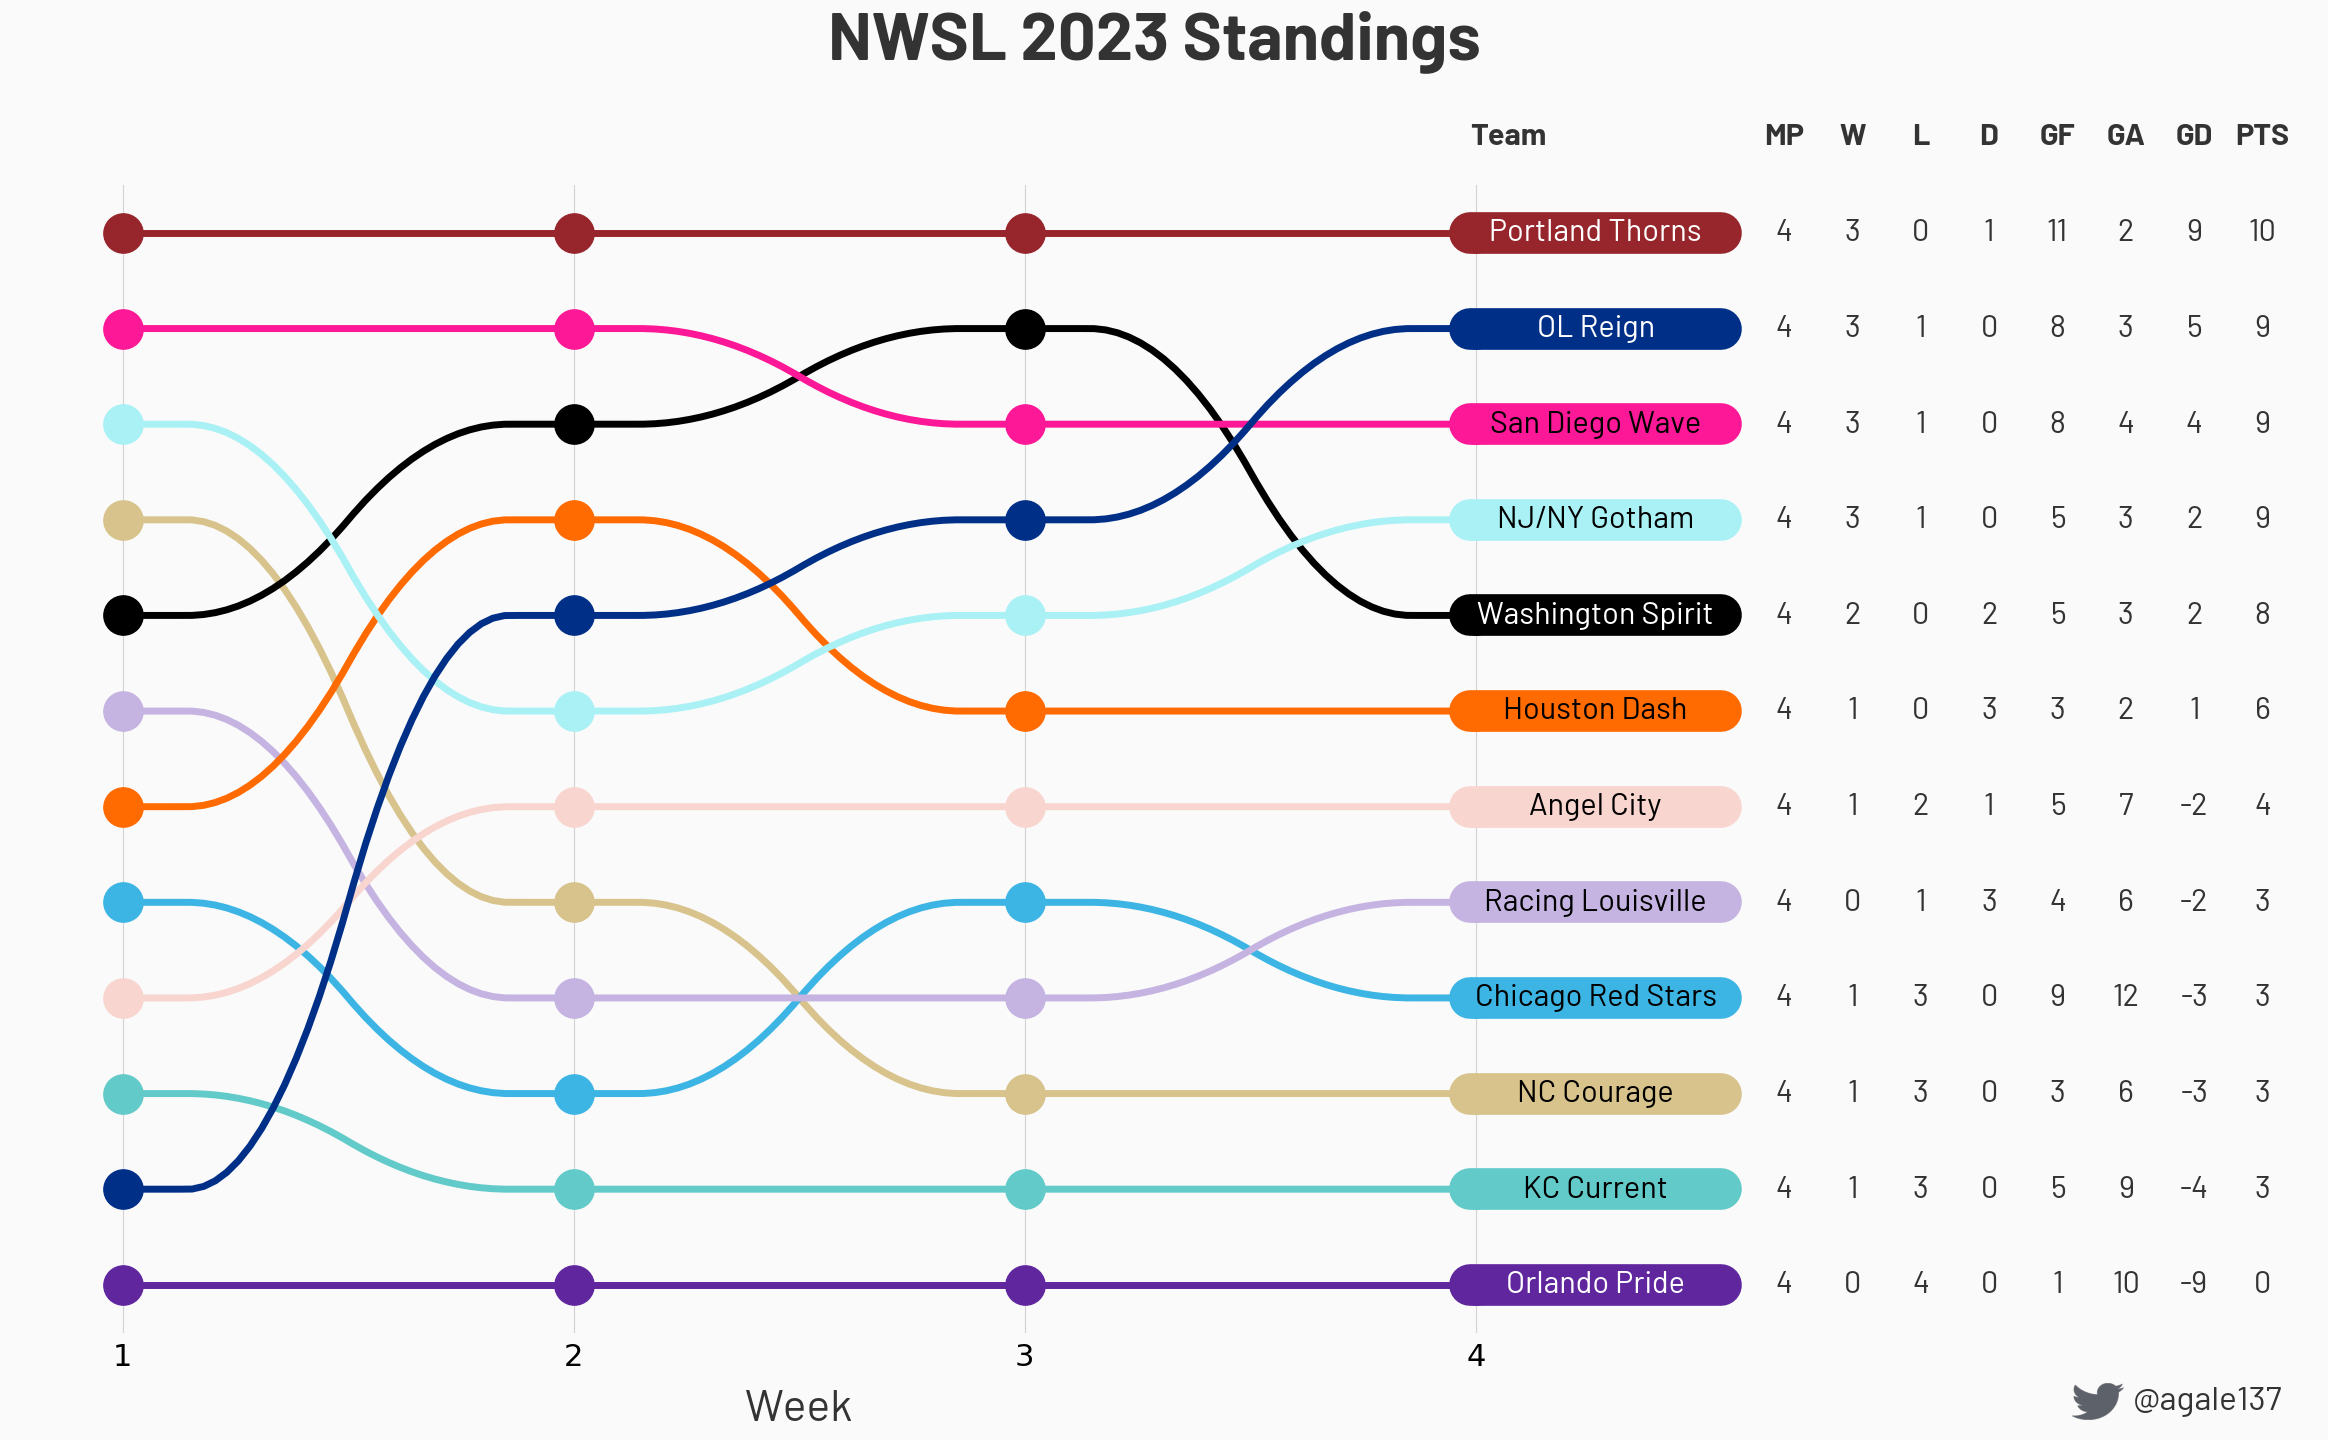

In [16]:
plot_standings_v2(
    df,
    df_table[["MP", "W", "L", "D", "GF", "GA", "GD", "PTS"]],
    folder="images/" + str(year),
    names=NWSL.NAMES,
    colors=NWSL.COLORS,
    text_colors=NWSL.TEXT_COLORS,
    title="NWSL " + str(year) + " Standings",
    label_width=0.44,
    twitter_x=1.04,
    plot_ratio=0.8,
)